***
# <font color="grey">Problem Sheet 4 Part B - Solutions</font>
***
$\newcommand{\vct}[1]{\mathbf{#1}}$
$\newcommand{\mtx}[1]{\mathbf{#1}}$
$\newcommand{\e}{\varepsilon}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\minimize}{\text{minimize}\quad}$
$\newcommand{\maximize}{\text{maximize}\quad}$
$\newcommand{\subjto}{\quad\text{subject to}\quad}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\trans}{T}$
$\newcommand{\ip}[2]{\langle {#1}, {#2} \rangle}$
$\newcommand{\zerovct}{\vct{0}}$
$\newcommand{\diff}[1]{\mathrm{d}{#1}}$

### Solution to Problem 4.1

In [31]:
import numpy as np
import numpy.linalg as la
import numpy.random as rnd
import numpy.fft as fft
import matplotlib.pyplot as plt
import cvxpy as cvx

The problem can be described as follows. We have a signal, here

\begin{equation*}
  f(x) = 1.7\sin(30x)+0.5\cos(9x)+0.5\sin(6x)-\cos(11x)+0.2\sin(13x).
\end{equation*}

which we would like to know between $0$ and $2\pi$. Due to time/cost constraints, we can only *sample* the signal at 30 points! The goal of this exercise is to see how one can recover the whole whole signal from only knowing these few samples. The reason why this works is that, even though the signal looks complicated, it arises as a sum of only a few periodic functions (sines and cosines). Such signal are not uncommon in signal processing.

In [10]:
# Define function of interest
def f(x):
    return 1.7*np.sin(30.*x)+0.5*np.cos(9.*x)+0.5*np.sin(6.*x)-np.cos(11.*x)+0.2*np.sin(13.*x)

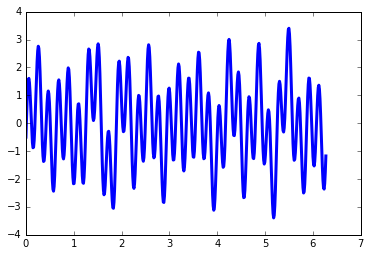

In [11]:
# Plot function
n = 512
T = 2*np.pi/n
xx = np.linspace(0,2*np.pi-T,n)
yy = f(xx)
% matplotlib inline
plt.plot(xx,yy,linewidth=3)
plt.show()

The red dots in the plot below indicate the points that we see. We know nothing else about the signal!

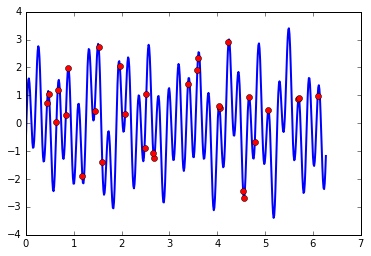

In [56]:
# Determine subsample (sample individual points from signal)
m = 30
p = rnd.permutation(n)
points = xx[p[:m]]
samples = f(points)
plt.plot(xx,yy,linewidth=2)
plt.plot(points,samples,'o', color='red')
plt.show()

We now show how to reconstruct the whole blue curve from the knowledge of the red dots alone. We do this by setting up an optimization problem of the form

\begin{equation*}
  \minimize \|\vct{x}\|_1 \quad \subjto \mtx{A}\vct{x}=\vct{b}
\end{equation*}

for suitable matrix $\mtx{A}$ and vector $\vct{b}$. How $\mtx{A}$ and $\vct{b}$ are constructed is described in the problem description. Below is the implementation.

In [30]:
# Set up data for optimization problem
D = fft.ifft(np.eye(n))
rD = np.concatenate((D.real, D.imag), axis=1)
A = rD[p[:m],:]
fy = fft.fft(yy)
b = np.dot(A,np.concatenate((fy.real, fy.imag), axis=0))

In [58]:
# Solve problem by minimizing the 1-norm using CVXPY
x = cvx.Variable(2*n)
constraints = [A*x == b]
obj = cvx.Minimize(cvx.norm(x,1))
prob = cvx.Problem(obj, constraints)
prob.solve()

1996.7999999985348

In [59]:
# Extract solution as array (problem: x is returned as column matrix object, we have to transform it into 1-D array)
x = np.array(x.value).transpose()[0]

Below we evaluate the result by comparing the reconstructed signal with the original one. The error is of order 10^{-7}. We also compare the reconstructed curve (second plot) to the original curve (first plot). As expected, there is no visible difference.

In [62]:
# Test result
newy_im = fft.ifft(x[:n]+1j*x[n:])
newy = newy_im.real
print la.norm(newy-yy,1)

3.08695396606e-07


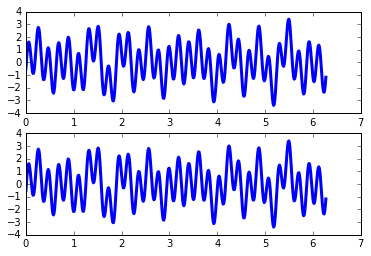

In [63]:
# Compare the original signal with the reconstructed one
plt.subplot(2,1,1)
plt.plot(xx,yy,linewidth=3)
plt.subplot(2,1,2)
plt.plot(xx,newy,linewidth=3)
plt.show()

Now the interesting question is: **how much understampling can we get away with?** To find out, we can repeat the previous experiment with values of m between $1$ and $512$ and find out where the method starts working. Obviously sampling only one point will not work (not enough information), and sampling all 512 points will work (we have all the information). As we say, $30$ points is already sufficient, but can we do with less?